### Kuramoto Model

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/Documentos/StuartLandauWBM/")

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd, gccmi_nd_ccc, gcmi_1d_cc, gcmi_nd_cc
from hoi.core import get_mi
from plot import circular_hist
from tqdm import tqdm

from src.models import simulate

/home/vinicius/anaconda3/envs/test_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [4]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def return_unique_terms(data, stim, shuffle=False):

    x = data.sel(roi="x") * np.conj(data.sel(roi="z"))

    if shuffle:
        x = shuffle_along_axis(x.data, 0)

    R1 = np.asarray((x * np.conj(x)).real)
    R2 = np.unwrap(np.angle(x))

    # Stims across trials
    stim = np.expand_dims(stim, axis=(0, 1))
    stim = np.tile(stim, (data.sizes["times"], 1)).squeeze().T

    I_S_12 = gccmi_nd_ccc(R1, R2, stim, traxis=0)
    I_S_1 = gcmi_nd_cc(stim, R1, traxis=0)
    I_S_2 = gcmi_nd_cc(stim, R2, traxis=0)
    R_12 = np.minimum(I_S_1, I_S_2)

    if shuffle:
        return np.maximum(I_S_1, I_S_2)
    return I_S_1 - R_12, I_S_2 - R_12

#### Simulation (no-delays) 

In [5]:
ntrials = 300
C = np.array([[0, 0, 1], [0, 0, 1], [0, 0, 0]]).T

decim = 15
fsamp = 1 / 1e-4
beta = 3.5
f = 40
a = -5
s = 32 / (2 * np.pi * f)

time = np.arange(-1, 3, 1 / fsamp)
Npoints = len(time)

time_start = 0
time_end = 1
g = 5

timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = jnp.exp(-(timestim**2) / (2 * s**2))
coupling = jnp.zeros_like(time)
coupling = coupling.at[ind].set(coupling[ind] + gaussian)

In [6]:
C.T

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 0]])

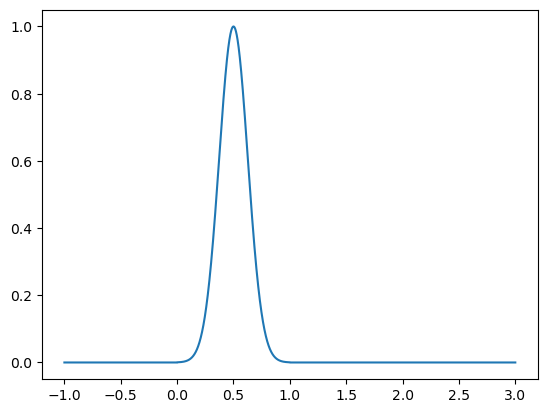

In [7]:
plt.plot(time, coupling)

In [8]:
simulate_jax = jax.vmap(
    simulate,
    in_axes=(None, 0, 0, None, None, None, None, None, None, None, 0, None, None, None),
)

In [9]:
Iext = np.zeros((2, Npoints))
Iext[:1, (time >= 0) & (time <= 0.2)] = 1
Amplitudes = np.linspace(1, 100, ntrials)
CS = Amplitudes[..., None, None] * coupling
seeds = np.random.randint(0, 10000, ntrials)

In [10]:
data_amp = np.stack(
    simulate_jax(
        C,
        CS[:, 0],
        CS[:, 0],
        f,
        a,
        fsamp,
        beta,
        Npoints,
        None,
        None,
        seeds,
        "kuramoto",
        "cpu",
        decim,
    )
)
data_amp = data_amp.squeeze()

In [11]:
data = xr.DataArray(
    data_amp,
    dims=("trials", "roi", "times"),
    coords=(Amplitudes, ["x", "y", "z"], time[::decim]),
)

In [12]:
uamp1, uphase1 = return_unique_terms(data, Amplitudes)
__iter = tqdm(range(50))
uc1 = [return_unique_terms(data, Amplitudes, True) for i in __iter]

100%|████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.71it/s]


Text(0.5, 0, 'time [s]')

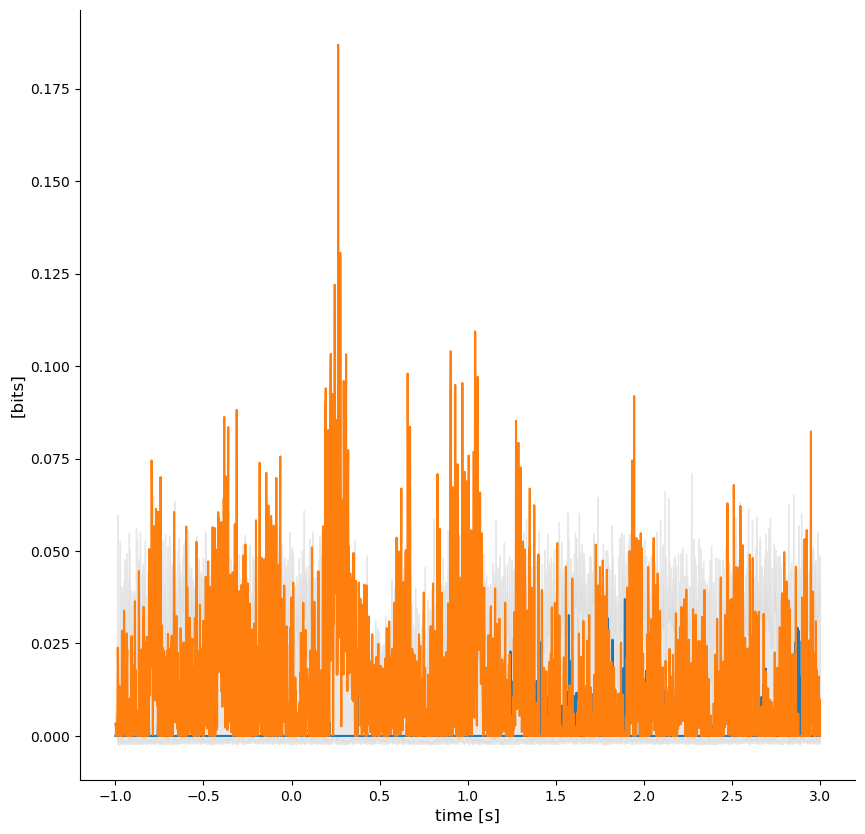

In [13]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
plt.plot(time[::decim], uamp1)
plt.plot(time[::decim], uphase1)
# plt.plot(time, CS[0, 0] / 10, c="k")
plt.fill_between(
    time[::decim],
    np.quantile(uc1, 0.05, axis=0),
    np.quantile(uc1, 0.95, axis=0),
    color="lightgray",
    alpha=0.5,
)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("time [s]", fontsize=12)

In [95]:
from mne.time_frequency import tfr_array_morlet

### Decompose in time-frequency domain

freqs = np.linspace(20, 60, 30)

S = tfr_array_morlet(
    data.values,
    fsamp / decim,
    freqs,
    freqs / 4,
    output="complex",
    n_jobs=1,
    zero_mean=False,
)

S = xr.DataArray(
    S,
    dims=("trials", "roi", "freqs", "times"),
    coords={"freqs": freqs, "times": data.times.values},
)

In [ ]:
### Compute phase and amplitude terms

# Define the function to compute MI using HOI and JAX
mi_fcn = get_mi("gc")

# vectorize the function to first and second dimension
gcmi = jax.vmap(jax.vmap(mi_fcn, in_axes=0), in_axes=0)

# Select data for nodes
x = S.sel(roi=[0]).data.squeeze()
y = S.sel(roi=[1]).data.squeeze()
z = S.sel(roi=[2]).data.squeeze()

# Edge activity (with and without normalisation)
e1 = x * np.conj(y)
e2 = y * np.conj(z)
e3 = x * np.conj(z)

# Real and Imag parts pf edge activity
e1r, e1i = np.real(e1), np.imag(e1)
e2r, e2i = np.real(e2), np.imag(e2)
e3r, e3i = np.real(e3), np.imag(e3)

# Stack complex values
E1 = np.stack((e1r, e1i), axis=1)
E2 = np.stack((e2r, e2i), axis=1)
E3 = np.stack((e3r, e3i), axis=1)
E12 = np.stack((e1r, e1i, e2r, e2i), axis=1)
E23 = np.stack((e2r, e2i, e3r, e3i), axis=1)
E123 = np.stack((e1r, e1i, e2r, e2i, e3r, e3i), axis=1)

# Swap axis 0 with 3 and 1 with 2
E1 = np.moveaxis(E1, [0, 1], [-1, -2])
E2 = np.moveaxis(E2, [0, 1], [-1, -2])
E3 = np.moveaxis(E3, [0, 1], [-1, -2])
E12 = np.moveaxis(E12, [0, 1], [-1, -2])
E23 = np.moveaxis(E23, [0, 1], [-1, -2])
E123 = np.moveaxis(E123, [0, 1], [-1, -2])

# Stims across trials
stim = data.trials.values
stim = np.expand_dims(stim, axis=(0, 1))
stim = np.tile(stim, (len(freqs), data.sizes["times"], 1, 1))

# # MI frequency domain
# mi_freq[i, :] = gcmi_nd_cc(X, Y, mvaxis=1, traxis=0)

# # Coherence
# coh[i, :] = np.abs(e1.mean(axis=0)).squeeze()

# # Phase-Locking Value
# plv[i, :] = np.abs(e1n.mean(axis=0)).squeeze()

# Copnorm
E1 = copnorm_nd(E1, axis=-1)
E2 = copnorm_nd(E2, axis=-1)
E3 = copnorm_nd(E3, axis=-1)
E12 = copnorm_nd(E12, axis=-1)
E23 = copnorm_nd(E23, axis=-1)
E123 = copnorm_nd(E123, axis=-1)
stim = copnorm_nd(stim, axis=-1)

# MIF for edge encoding
mif_e1 = gcmi(E1, stim).T
mif_e2 = gcmi(E2, stim).T
mif_e3 = gcmi(E3, stim).T
mif_e12 = gcmi(E12, stim).T
mif_e23 = gcmi(E23, stim).T
mif_e123 = gcmi(E123, stim).T

red = np.minimum(mif_e1, mif_e2)

syn = mif_e123 - np.maximum(mif_e1, mif_e2)

## Plot

times = data.times.values
ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(mif_e3, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title(
    "Coherence between node 2 and 3 using Frequency-domain MI (Kuramoto Chain)"
)
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(mif_e123, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title("Total MI I(e1, e2; coupling)")
ax.set_xlabel("Time (samples)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(red, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title("Redundancy")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

ax = plt.subplot()
# Plot single-trial and time-frequency MI
mi = xr.DataArray(syn, dims=("times", "freqs"), coords=(times, freqs))
# Plot trial-average time-frequency MI
mi.plot(x="times", y="freqs", cmap="viridis", vmin=0, vmax=0.5)
# mi.plot.title('ciao')
ax.set_title("Synergy")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
plt.show()

In [67]:
from pid_sx import PIDSx, compute_pid_sx

In [93]:
class PIDSx:
    """Estimate PID atoms based on shared exclusions (3 variables).

    Note: Code based on Ehrlich et al., 2024.
    """

    def __init__(self, k=4, batch_size=None):
        """Initialize PID estimator.

        Parameters
        ----------
        k : int, optional
            Number of neighbours for KNN-based redundancy, by default 4.
        batch_size : int, optional
            Number of samples to compute at once in KNN. If None, all samples
            at the same time. By default None.

        Returns
        -------
        PIDSx
            PID estimator.
        """
        self.k = k
        self.batch_size = batch_size

    def _prepare_data(self, x, y):
        """Concatenate and reshape data."""
        self.x = jnp.concatenate([x[:, [i]] for i in range(x.shape[1])] + [y], axis=1)
        
        if self.x.ndim == 2:
            self.x = self.x[..., None]

        # shape (n_features, n_variables, n_samples)
        self.x = self.x.transpose(1, 2, 0)

    def get_atom(self, atom):
        """Get atom from PID decomposition."""
        if atom not in self.decomp:
            msg = f"{atom} not in PID decomposition."
            raise ValueError(msg)
        return self.decomp[atom]

    def fit(self, x1, x2, y):
        """Compute PID atoms (3 variables)."""
        # reshape data and concatenate
        self._prepare_data(np.hstack([x1, x2]), y)
        n_x1_feats = x1.shape[1]
        n_x2_feats = x2.shape[1]
        # n_y_feats = y.shape[1]
        print(self.x.shape)
        self.decomp = compute_pid_sx(
            self.x,
            self.k,
            self.batch_size,
            n_x1_feats,
            n_x2_feats,
        )
        return self.decomp

In [94]:
estimator = PIDSx()

estimator.fit(R1, R2, Amplitudes[:, None])

(5335, 1, 300)


{'syn': Array([0.], dtype=float64),
 'uniq_0': Array([0.], dtype=float64),
 'uniq_1': Array([0.00400749], dtype=float64),
 'red': Array([0.00480898], dtype=float64)}

In [78]:
[ estimator.fit(R1[:, t][:, None], R2[:, t][:, None], Amplitudes[:, None]) for t in tqdm(range(R1.shape[1])) ]

 13%|███████                                              | 355/2667 [01:47<13:40,  2.82it/s]
KeyboardInterrupt



In [31]:
x = data.sel(roi="x") * np.conj(data.sel(roi="y"))


R1 = np.asarray((x * np.conj(x)).real)
R2 = np.unwrap(np.angle(x))

In [ ]:
estimator.fit(R1.T[:, None], R2.T[:, None], Amplitudes)

In [61]:
x = jnp.hstack([R1, R2])
y = Amplitudes[:, None]

In [64]:
x = jnp.concatenate([x[:, [i]] for i in range(x.shape[1])] + [y], axis=1)

In [65]:
if x.ndim == 2:
    x = x[..., None]

# shape (n_features, n_variables, n_samples)
x = x.transpose(1, 2, 0)

In [68]:
compute_pid_sx(
            x,
            4,
            None,
            len(time),
            len(time),
        )

{'syn': Array([nan], dtype=float64),
 'uniq_0': Array([nan], dtype=float64),
 'uniq_1': Array([nan], dtype=float64),
 'red': Array([nan], dtype=float64)}